## CE9010: Introduction to Data Analysis
## Semester 2 2018/19
## Xavier Bresson
<hr>

## Tutorial 8: Neural networks
## Objectives
### $\bullet$ Coding 3-layer neural network
### $\bullet$ Implementing backpropagation
### $\bullet$ Understanding bias vs. variance 
<hr>

In [1]:
# Import libraries

# math library
import numpy as np

# remove warning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# computational time
import time

# import mat data
import scipy.io

# dynamic 3D rotations:
#%matplotlib notebook 
# no 3D rotations but cleaner images:
%matplotlib inline    
import matplotlib.pyplot as plt

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

# high definition picture
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')

# visualize 2D images
import scipy.ndimage

# import mat data
import scipy.io

# random number
import random

# colormap
import matplotlib.cm as cm 

# for one-hot vector
from scipy.sparse import coo_matrix

## 1. Load training and test datasets
<hr>

In [13]:
X_train = np.load('data/nn_train_test_sets.npz')['X_train']
y_train = np.load('data/nn_train_test_sets.npz')['y_train']
X_test = np.load('data/nn_train_test_sets.npz')['X_test']
y_test = np.load('data/nn_train_test_sets.npz')['y_test']

print('Nb training data:',X_train.shape[1])
print('Nb test data:',X_test.shape[1])
print('Nb data features:',X_train.shape[0])

print(X_train.shape)
print(y_train.shape)
print(y_train[:10])
print(X_test.shape)
print(y_test.shape)

Nb training data: 1000
Nb test data: 4000
Nb data features: 400
(400, 1000)
(1000, 1)
[[1]
 [2]
 [7]
 [8]
 [2]
 [5]
 [8]
 [2]
 [6]
 [5]]
(400, 4000)
(4000, 1)


## 2. Visualize the datasets
<hr>

Hint: You may use function `display_data`.

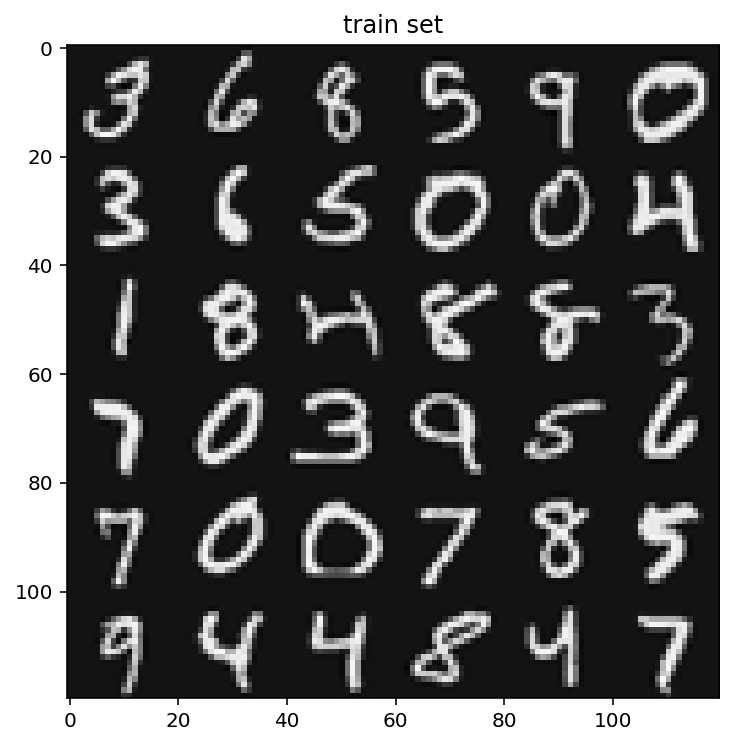

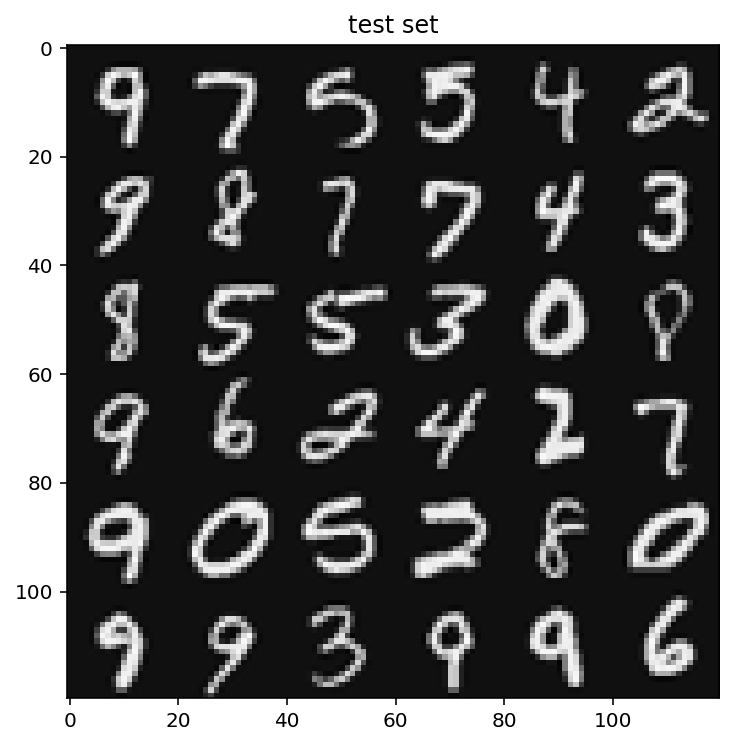

In [4]:
def display_data(X,width,height,nrows,ncols,title):

    big_picture = np.zeros((height*nrows,width*ncols))
    indices_to_display = random.sample(range(X.shape[1]), nrows*ncols)
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0       
        iimg = X[:,idx].reshape(width,height).T       
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    plt.title(title)
    img = scipy.misc.toimage( big_picture ).convert('RGBA')
    plt.imshow(img,cmap = cm.Greys_r)
    
    
#YOUR CODE HERE
display_data(X_train,20,20,6,6,'train set')
display_data(X_test,20,20,6,6,'test set')



## 3. Z-score the datasets
<hr>


In [10]:
#YOUR CODE HERE
X_train -= np.mean(X_train,axis=0)
X_train /= np.std(X_train,axis=0)

X_test -= np.mean(X_test,axis=0)
X_test /= np.std(X_test,axis=0)


## 4. Implement a 3-layer neural network classifier.
<hr>

The input layer has $n_1=d=400$ neurons.
The hidden layer has $n_2=25$ neurons.
The output layer has $n_3=K=10$ neurons.


In [11]:
K = 10 # number of classes
n = X_train.shape[1] # number of training data

n1 = 400
n2 = 25
n3 = K

## 4.1 Function definitions
<hr>


In [12]:
# one-hot transform function
def convert_to_one_hot(X,max_val=None):
    N = X.size
    data = np.ones(N,dtype=int)
    sparse_out = coo_matrix((data,(np.arange(N),X.ravel())), shape=(N,max_val))
    return np.array(sparse_out.todense().T)

#Example:
a = np.array([1, 7, 5, 3, 2, 4, 0, 4])
print(a)
print(convert_to_one_hot(a,10)) 


# sigmoid function
def sigmoid(z):
    sigmoid_f = 1 / (1 + np.exp(-z)) 
    return sigmoid_f 


# derivate of the sigmoid function
def sigmoid_derivate(z):
    sigm = sigmoid(z)
    return sigm* (1-sigm)


# accuracy function
def compute_acc(y,ygt):
    diff = (y == ygt).astype('int')
    accuracy = 100* sum(diff)/ y.shape[0]
    return accuracy

[1 7 5 3 2 4 0 4]
[[0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


## 4.2 Convert the training label vector `y_train`, with values in ${1,2,...,K}$, to one-hot vector.
<hr>

Hint: You may use function `convert_to_one_hot(y,K)` with `y` having values in ${0,1,...,K-1}$.

In [34]:
#YOUR CODE HERE
Yhat = convert_to_one_hot(y_train-1,max_val=10)
idx=3
print(Yhat[:,idx],y_train[idx])


[0 0 0 0 0 0 0 1 0 0] [8]


## 4.3 Initialize the weight matrices $W^1$ and $W^2$ with the formula
$$
W^l = U\Big[ -\frac{2}{\sqrt{n_l}}, \frac{2}{\sqrt{n_l}} \Big],
$$
with $U$ being the uniform distribution.
<hr>

Hint: You may use function `np.random.uniform`.

In [32]:
#YOUR CODE HERE
a = 2/ np.sqrt(n1)
W1 = np.random.uniform(-a,a,[n2,n1+1])
print(W1.shape)
print(W1[0,:3])

a = 2/ np.sqrt(n2)
W2 = np.random.uniform(-a,a,[n3,n2+1])
print(W2.shape)


(25, 401)
[-0.01542791 -0.07443608  0.04375527]
(10, 26)


## 4.4 Implement the backpropagation algorithm from Lecture 10.
<hr>

**Backpropagation algorithm**

Step 1. Forward pass (compute all activations)

$$
\hspace{-4cm}\textrm{For } l=1,2,...,L
$$
$$
y^{l+1} = 
\sigma \left(W^l
\left[ 
\begin{array}{cccc}
1  \\
y^l
\end{array} 
\right]
\right)
$$

Step 2. Backward pass (compute all gradients of weight parameters)

$$
\hspace{-4cm}\delta^{l=L} = y^L - \hat{y}
$$

$$
\hspace{-3cm}\textrm{For } l=L-1,L-2,...,1
$$

$$
\nabla_{W^l} 
 = \frac{1}{n} \delta^{l+1} 
\left[ 
\begin{array}{cccc}
1  \\
y^l
\end{array} 
\right]^T
$$

$$
W^l \leftarrow W^l - \tau \nabla_{W^l} 
$$

$$
\hspace{1cm} \delta^{l} = (\bar{W}^l)^T \delta^{l+1} \ . \ \sigma'\left(y^l \right)
$$

with 

$$
W^l = 
\left[ 
\begin{array}{cccc}
|  \\
W_0^l & \bar{W}^l \\
| & 
\end{array} 
\right]
$$



The learning rate is $\tau=0.2$ and the number of iterations is $5000$. Do not use any regularization at this moment $\lambda=0$. 

Note the accuracy of the train set and the test set for $n_2=25$ and $\lambda=0$.


In [35]:
tau = 0.2 # learning rate
lamb = 0  # regularization

# iterate
for iter in range(5000):
    
    # forward pass
    #YOUR CODE HERE
    Y1 = X_train
    #print(Y1.shape)
    Y1bias = np.insert(Y1,0,1,axis=0)
    #print(Y1bias.shape)
    Y2 = sigmoid(W1.dot(Y1bias))
    #print(Y2.shape)
    Y2bias = np.insert(Y2,0,1,axis=0)
    #print(Y2bias.shape)
    Y3 = sigmoid(W2.dot(Y2bias))
    #print(Y3.shape)
    
    # backward pass
    #YOUR CODE HERE
    Delta3 = Y3 - Yhat
    Grad2 = 1/n* Delta3.dot(Y2bias.T)
    W2 = W2 - tau * Grad2
    W2bar = W2[:,1:n2+1]
    
    Delta2 = W2bar.T.dot(Delta3)*sigmoid_derivate(Y2)
    Grad1 = 1/n* Delta2.dot(Y1bias.T)
    W1 = W1 - tau * Grad1
    
    # print intermediate result
    if not iter%500:
        
        # loss 
        loss = -1/n* ( np.sum(Yhat* np.log(Y3+1e-10)) + \
                      np.sum((1-Yhat)* np.log((1-Y3)+1e-10)) ) + \
                lamb* ( np.sum(W1) + np.sum(W2) )
        
        # train accuracy
        Y3_classes = np.argmax(Y3,axis=0)
        Ygt = np.argmax(Yhat,axis=0)
        acc = compute_acc(Y3_classes,Ygt)
        
        # test accuracy (with forward pass on the test set)
        Y1_test = X_test
        Y1bias_test = np.insert(Y1_test,0,1,axis=0)
        Y2_test = sigmoid(W1.dot(Y1bias_test))
        Y2bias_test = np.insert(Y2_test,0,1,axis=0)
        Y3_test = sigmoid(W2.dot(Y2bias_test))
        Y3_classes_test = np.argmax(Y3_test,axis=0)
        Ygt_test = (y_test-1).squeeze()
        acc_test = compute_acc(Y3_classes_test,Ygt_test)
        
        # print
        print('iter:',iter,'loss:',loss,'train acc:',acc,'test acc:',acc_test)
        
    
print('iter:',iter+1,'loss:',loss,'train acc:',acc,'test acc:',acc_test)


iter: 0 loss: 4.216345017468611 train acc: 11.9 test acc: 9.525
iter: 500 loss: 1.103872333686137 train acc: 87.1 test acc: 83.925
iter: 1000 loss: 0.840693422323704 train acc: 89.2 test acc: 85.4
iter: 1500 loss: 0.7272981444824352 train acc: 90.0 test acc: 85.575
iter: 2000 loss: 0.7045218808970387 train acc: 90.2 test acc: 85.4
iter: 2500 loss: 0.6805886387642716 train acc: 90.2 test acc: 84.75
iter: 3000 loss: 0.6480244132056249 train acc: 90.8 test acc: 84.025
iter: 3500 loss: 0.6348391414317478 train acc: 90.9 test acc: 83.75
iter: 4000 loss: 0.6571215777525706 train acc: 89.4 test acc: 83.15
iter: 4500 loss: 0.7237353207172517 train acc: 87.9 test acc: 81.625
iter: 5000 loss: 0.7237353207172517 train acc: 87.9 test acc: 81.625


## 5. Increase the learning capacity of the network by taking $n_2=100$.
<hr>

Note the accuracy of the train set and the test set for $n_2=100$ and $\lambda=0$.

In [38]:
#YOUR CODE HERE
n2 = 100

a = 2/ np.sqrt(n1)
W1 = np.random.uniform(-a,a,[n2,n1+1])
print(W1.shape)
print(W1[0,:3])

a = 2/ np.sqrt(n2)
W2 = np.random.uniform(-a,a,[n3,n2+1])
print(W2.shape)

tau = 0.2 # learning rate
lamb = 0  # regularization

# iterate
for iter in range(5000):
    
    # forward pass
    #YOUR CODE HERE
    Y1 = X_train
    #print(Y1.shape)
    Y1bias = np.insert(Y1,0,1,axis=0)
    #print(Y1bias.shape)
    Y2 = sigmoid(W1.dot(Y1bias))
    #print(Y2.shape)
    Y2bias = np.insert(Y2,0,1,axis=0)
    #print(Y2bias.shape)
    Y3 = sigmoid(W2.dot(Y2bias))
    #print(Y3.shape)
    
    # backward pass
    #YOUR CODE HERE
    Delta3 = Y3 - Yhat
    Grad2 = 1/n* Delta3.dot(Y2bias.T)
    W2 = W2 - tau * Grad2
    W2bar = W2[:,1:n2+1]
    
    Delta2 = W2bar.T.dot(Delta3)*sigmoid_derivate(Y2)
    Grad1 = 1/n* Delta2.dot(Y1bias.T)
    W1 = W1 - tau * Grad1
    
    # print intermediate result
    if not iter%500:
        
        # loss 
        loss = -1/n* ( np.sum(Yhat* np.log(Y3+1e-10)) + \
                      np.sum((1-Yhat)* np.log((1-Y3)+1e-10)) ) + \
                lamb* ( np.sum(W1) + np.sum(W2) )
        
        # train accuracy
        Y3_classes = np.argmax(Y3,axis=0)
        Ygt = np.argmax(Yhat,axis=0)
        acc = compute_acc(Y3_classes,Ygt)
        
        # test accuracy (with forward pass on the test set)
        Y1_test = X_test
        Y1bias_test = np.insert(Y1_test,0,1,axis=0)
        Y2_test = sigmoid(W1.dot(Y1bias_test))
        Y2bias_test = np.insert(Y2_test,0,1,axis=0)
        Y3_test = sigmoid(W2.dot(Y2bias_test))
        Y3_classes_test = np.argmax(Y3_test,axis=0)
        Ygt_test = (y_test-1).squeeze()
        acc_test = compute_acc(Y3_classes_test,Ygt_test)
        
        # print
        print('iter:',iter,'loss:',loss,'train acc:',acc,'test acc:',acc_test)
        
    
print('iter:',iter+1,'loss:',loss,'train acc:',acc,'test acc:',acc_test)



W1_no_regularization = W1 # for visualization

(100, 401)
[-0.03447205  0.02006332  0.04365087]
(10, 101)
iter: 0 loss: 9.08678044683067 train acc: 9.3 test acc: 12.45
iter: 500 loss: 0.8312966246146556 train acc: 90.4 test acc: 86.875
iter: 1000 loss: 0.563220328303287 train acc: 94.7 test acc: 88.5
iter: 1500 loss: 0.44317991524780653 train acc: 96.1 test acc: 89.075
iter: 2000 loss: 0.36795172594552605 train acc: 96.9 test acc: 89.225
iter: 2500 loss: 0.3140804792163927 train acc: 97.5 test acc: 89.175
iter: 3000 loss: 0.27279401369682466 train acc: 98.0 test acc: 88.975
iter: 3500 loss: 0.2399549033640323 train acc: 98.7 test acc: 88.975
iter: 4000 loss: 0.21324363505407007 train acc: 99.1 test acc: 89.0
iter: 4500 loss: 0.19119150206456684 train acc: 99.1 test acc: 88.725
iter: 5000 loss: 0.19119150206456684 train acc: 99.1 test acc: 88.725


## 6. Regularize the network with $\lambda=0.005$
<hr>

Note the accuracy of the train set and the test set.

In [40]:
#YOUR CODE HERE
#YOUR CODE HERE
n2 = 100

a = 2/ np.sqrt(n1)
W1 = np.random.uniform(-a,a,[n2,n1+1])
print(W1.shape)
print(W1[0,:3])

a = 2/ np.sqrt(n2)
W2 = np.random.uniform(-a,a,[n3,n2+1])
print(W2.shape)

tau = 0.2 # learning rate
lamb = 0.01  # regularization

# iterate
for iter in range(5000):
    
    # forward pass
    #YOUR CODE HERE
    Y1 = X_train
    #print(Y1.shape)
    Y1bias = np.insert(Y1,0,1,axis=0)
    #print(Y1bias.shape)
    Y2 = sigmoid(W1.dot(Y1bias))
    #print(Y2.shape)
    Y2bias = np.insert(Y2,0,1,axis=0)
    #print(Y2bias.shape)
    Y3 = sigmoid(W2.dot(Y2bias))
    #print(Y3.shape)
    
    # backward pass
    #YOUR CODE HERE
    Delta3 = Y3 - Yhat
    Grad2 = 1/n* Delta3.dot(Y2bias.T) + 2* lamb* W2
    W2 = W2 - tau * Grad2
    W2bar = W2[:,1:n2+1]
    
    Delta2 = W2bar.T.dot(Delta3)*sigmoid_derivate(Y2)
    Grad1 = 1/n* Delta2.dot(Y1bias.T) + 2* lamb* W1
    W1 = W1 - tau * Grad1
    
    # print intermediate result
    if not iter%500:
        
        # loss 
        loss = -1/n* ( np.sum(Yhat* np.log(Y3+1e-10)) + \
                      np.sum((1-Yhat)* np.log((1-Y3)+1e-10)) ) + \
                lamb* ( np.sum(W1) + np.sum(W2) )
        
        # train accuracy
        Y3_classes = np.argmax(Y3,axis=0)
        Ygt = np.argmax(Yhat,axis=0)
        acc = compute_acc(Y3_classes,Ygt)
        
        # test accuracy (with forward pass on the test set)
        Y1_test = X_test
        Y1bias_test = np.insert(Y1_test,0,1,axis=0)
        Y2_test = sigmoid(W1.dot(Y1bias_test))
        Y2bias_test = np.insert(Y2_test,0,1,axis=0)
        Y3_test = sigmoid(W2.dot(Y2bias_test))
        Y3_classes_test = np.argmax(Y3_test,axis=0)
        Ygt_test = (y_test-1).squeeze()
        acc_test = compute_acc(Y3_classes_test,Ygt_test)
        
        # print
        print('iter:',iter,'loss:',loss,'train acc:',acc,'test acc:',acc_test)
        
    
print('iter:',iter+1,'loss:',loss,'train acc:',acc,'test acc:',acc_test)




(100, 401)
[ 0.04332999 -0.09433804  0.05279169]
(10, 101)
iter: 0 loss: 6.7623128623598125 train acc: 9.5 test acc: 15.075
iter: 500 loss: 0.5921904321461136 train acc: 86.2 test acc: 81.75
iter: 1000 loss: 0.39350510937884753 train acc: 87.4 test acc: 83.0
iter: 1500 loss: 0.3590425569417408 train acc: 87.6 test acc: 83.425
iter: 2000 loss: 0.3548965500620893 train acc: 87.8 test acc: 83.575
iter: 2500 loss: 0.3575647644673112 train acc: 87.6 test acc: 83.675
iter: 3000 loss: 0.3609854427303092 train acc: 87.7 test acc: 83.775
iter: 3500 loss: 0.36310587470069033 train acc: 87.7 test acc: 83.925
iter: 4000 loss: 0.36353074800682794 train acc: 87.6 test acc: 84.025
iter: 4500 loss: 0.36263854007413343 train acc: 87.6 test acc: 84.025
iter: 5000 loss: 0.36263854007413343 train acc: 87.6 test acc: 84.025


## 7. Visualize the learned features [Bonus]
<hr>


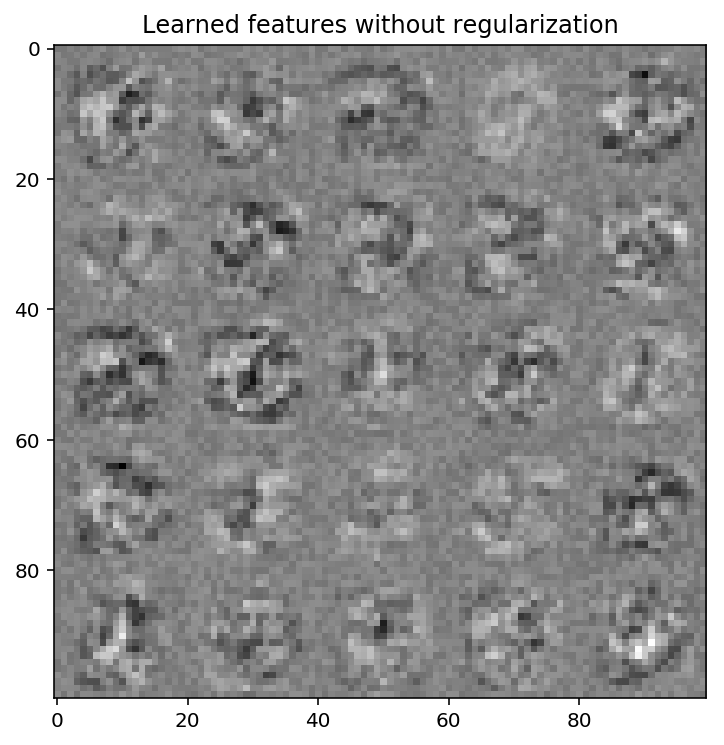

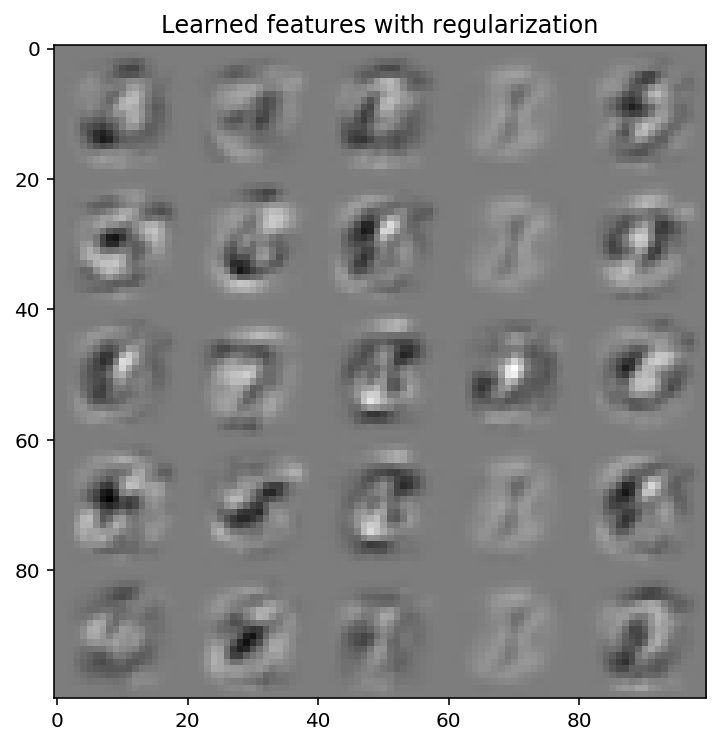

In [41]:
W1bar = W1_no_regularization[:,1:].T
display_data(W1bar,20,20,5,5,'Learned features without regularization')

W1bar = W1[:,1:].T
display_data(W1bar,20,20,5,5,'Learned features with regularization')